# Spam Detection Using SVM and Random Forest Classifiers

## Introduction
In this notebook, we will develop a machine learning model to detect spam emails using the SMS Spam Collection dataset. Spam detection is a critical application in the field of natural language processing (NLP), helping to filter out unwanted and potentially harmful messages from users' inboxes.

## Dataset
The dataset used in this project is the SMS Spam Collection, sourced from the UCI Machine Learning Repository. This dataset contains 5,574 SMS messages labeled as 'ham' (legitimate) or 'spam'. You can find more details about the dataset [here](https://archive.ics.uci.edu/dataset/228/sms+spam+collection).

## Libraries Used
We will utilize the following Python libraries in this notebook:
- `pandas`: For data manipulation and analysis.
- `scikit-learn`: For machine learning algorithms and tools, including TfidfVectorizer for feature extraction.
- `matplotlib` and `seaborn`: For data visualization.

## Steps Covered
In this notebook, we will cover the following steps:
1. **Loading the Data**: Importing the dataset and understanding its structure.
2. **Data Preprocessing**: Cleaning and preparing the data for analysis.
3. **Feature Extraction**: Using TfidfVectorizer to convert text data into numerical features.
4. **Model Training**: Training a machine learning model to classify messages as 'spam' or 'ham'.
5. **Model Evaluation**: Evaluating the performance of the model using various metrics.

## Acknowledgments
We would like to thank the UCI Machine Learning Repository for providing the SMS Spam Collection dataset. This project is inspired by the need to develop efficient and accurate spam detection systems to enhance email security.

Let's get started!




In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv('spam.tsv', sep='\t')

## Initial Data Exploration

Before diving into the data preprocessing and model training steps, let's take a quick look at our dataset to understand its structure and key statistics.

### Data Overview

Here are the first few rows of the dataset:



In [6]:
df.head()

,label,message,length,punct
0,ham,"Go until jurong point, crazy.. Available only ...",111,9
1,ham,Ok lar... Joking wif u oni...,29,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,6
3,ham,U dun say so early hor... U c already then say...,49,6
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,2


## Checking for Missing Values:
It is important to ensure that our dataset does not contain any missing values, as these could affect our model's performance. We can check for NaN values using the following code:

In [7]:
df.isna().sum()

label      0
message    0
length     0
punct      0
dtype: int64

The output shows that there are no missing values in any of the columns.

## Statistical Summary
Let's look at some basic statistics of the numerical columns in our dataset to get a sense of the distribution of message lengths and punctuation counts.

In [8]:
df.describe()

,length,punct
count,5572.000000,5572.000000
mean,80.489950,4.177495
std,59.942907,4.623919
min,2.000000,0.000000
25%,36.000000,2.000000
50%,62.000000,3.000000
75%,122.000000,6.000000
max,910.000000,133.000000


## Checking and Handling Data Imbalance

### Data Imbalance Check

In real-world datasets, it's common to encounter imbalanced classes, which can significantly affect the performance of machine learning models. Let's check if our dataset is balanced by looking at the distribution of 'ham' and 'spam' labels.



In [9]:
df['label'].value_counts()

label
ham     4825
spam     747
Name: count, dtype: int64

To get a clearer picture, let's look at the percentage distribution of each label:

In [10]:
df['label'].value_counts()/len(df)*100

label
ham     86.593683
spam    13.406317
Name: count, dtype: float64

([<matplotlib.patches.Wedge at 0x1b5b19c4440>,
 [Text(-0.490596282293446, -1.0951325434849655, 'Ham'),
  Text(0.4497133057636077, 1.0038714771419537, 'Spam')])

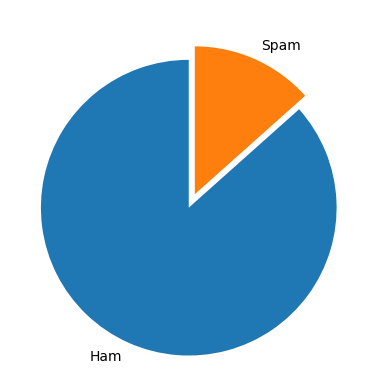

In [11]:
labels = ['Ham', 'Spam']
label_count = df['label'].value_counts()
explode = (0.1, 0)

# plotting the pie chart
fig, ax = plt.subplots()
ax.pie(label_count.values, explode=explode, labels=labels, startangle=90)

## Balancing the Dataset
To ensure our model performs well and is not biased towards the majority class, we need to balance the dataset. We can do this by sampling an equal number of 'ham' and 'spam' messages. Here's how we can achieve that:

Separate the 'ham' and 'spam' messages:

In [12]:
ham = df[df['label'] == 'ham']
spam = df[df['label'] == 'spam']

Sample the 'ham' messages to match the number of 'spam' messages:


In [13]:
ham =ham.sample(spam.shape[0])

Verify the shapes of the new balanced datasets:

In [14]:
ham.shape, spam.shape

((747, 4), (747, 4))

The output confirms that both 'ham' and 'spam' now have the same length.


To continue with preparing the data for analysis, here's the Python code that balances the dataset and concatenates the balanced 'ham' and 'spam' subsets. This code also includes displaying the shape and first few rows of the concatenated dataset:

In [15]:
data = pd.concat([ham, spam], ignore_index=True)

In [16]:
data.shape

(1494, 4)

In [17]:
data.head()

,label,message,length,punct
0,ham,You didn't have to tell me that...now i'm thin...,89,7
1,ham,I am going to film 2day da. At 6pm. Sorry da.,45,3
2,ham,Not to worry. I'm sure you'll get it.,37,4
3,ham,Are you ok. What happen to behave like this,43,1
4,ham,Moji i love you more than words. Have a rich day,48,1


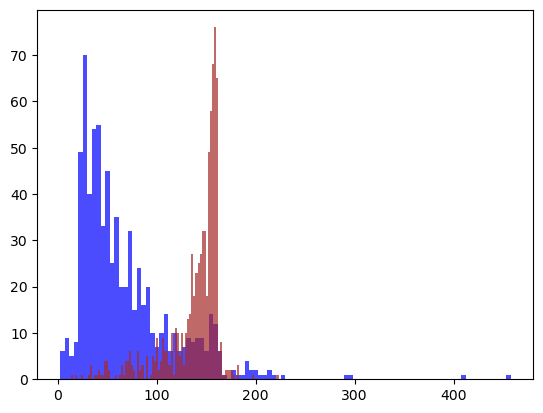

In [18]:
plt.hist(data[data['label']=='ham']['length'], bins=100, alpha=0.7, color='blue');
plt.hist(data[data['label']=='spam']['length'], bins=100, alpha=0.7, color='brown');

The distribution function for message length shows that 'ham' messages tend to peak at shorter lengths compared to 'spam' messages. However, there is a significant overlap between the two distributions.

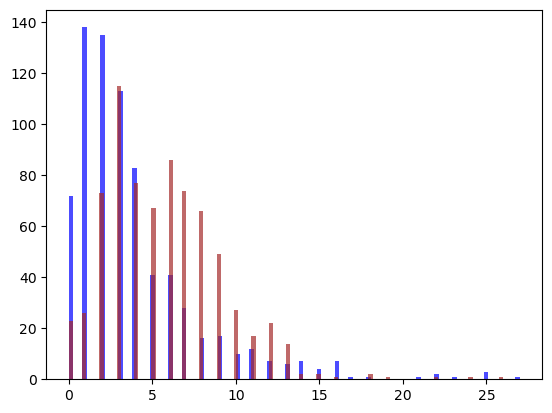

In [19]:
plt.hist(data[data['label']=='ham']['punct'], bins=100, alpha=0.7, color='blue');
plt.hist(data[data['label']=='spam']['punct'], bins=100, alpha=0.7, color='brown');

For the punctuation count distribution, the two distributions overlap significantly, making it difficult to visually distinguish between 'ham' and 'spam' messages. Therefore, there's not much to infer from this feature.

Next we split the data into train and test data set and then use TfidfVectorizer to extract features from the data. 

## Hyperparameter Tuning with Grid Search

To optimize the performance of our RandomForestClassifier, we use GridSearchCV to find the best number of estimators (trees) for the classifier. GridSearchCV performs an exhaustive search over a specified parameter grid to find the best combination of parameters.

### Steps:

1. **Pipeline Creation:**
   - We create a pipeline that includes `TfidfVectorizer` for converting text data into TF-IDF features and `RandomForestClassifier` for classification.

2. **Parameter Grid Definition:**
   - We define a parameter grid for the `n_estimators` parameter of the `RandomForestClassifier`, specifying the values `[10, 50, 100, 200]` to search through.

3. **GridSearchCV Initialization:**
   - We initialize `GridSearchCV` with the pipeline, parameter grid, and specify 5-fold cross-validation (`cv=5`).
   - We set `n_jobs=-1` to utilize all available processors for parallel computation.
   - We use `accuracy` as the scoring metric.

4. **Model Training:**
   - We train the model using `grid_search.fit(X_train, y_train)` to find the best parameters based on the training data.

5. **Best Parameters:**
   - After the grid search, we print the best parameters found using `grid_search.best_params_`.

Here is the code implementation:

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
X_train, X_test, y_train, y_test = train_test_split(data['message'], data['label'], test_size=0.3, random_state=47, shuffle=True)

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Create a pipeline with TfidfVectorizer and RandomForestClassifier

pipeline = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ('classifier', RandomForestClassifier(random_state=47))
])

# Define the parameter grid for GridSearchCV

param_grid = {
    "classifier__n_estimators": [10, 50, 100, 200]
}

# Initialize Greid SearchCV

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# train the model with GridSearchCV to find the best parameters
grid_search.fit(X_train, y_train)

# Print the best paramenters
print("Best parameters found: ", grid_search.best_params_)



Best parameters found:  {'classifier__n_estimators': 200}


## Model Evaluation

After identifying the best parameters for the RandomForestClassifier using GridSearchCV, we can evaluate the performance of the model on the test data. This evaluation includes generating predictions, calculating performance metrics, and analyzing the results.

### Steps:

1. **Predictions:**
   - Using the best estimator found by GridSearchCV, we predict the labels for the test set.

2. **Performance Metrics:**
   - We generate a classification report, which includes precision, recall, F1-score, and support for each class.
   - We compute the confusion matrix to visualize the performance of the classifier in terms of true positives, true negatives, false positives, and false negatives.
   - We calculate the overall accuracy score of the model.

In [23]:
# Predict the test set results with the best model
y_pred = grid_search.best_estimator_.predict(X_test)
# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

         ham       0.94      0.99      0.96       234
        spam       0.99      0.93      0.96       215

    accuracy                           0.96       449
   macro avg       0.96      0.96      0.96       449
weighted avg       0.96      0.96      0.96       449

Confusion Matrix:
 [[232   2]
 [ 16 199]]
Accuracy Score: 0.9599109131403119


## SVM Classifier for Spam Detection

In this section, we will use Support Vector Machine (SVM) classifiers to predict spam messages. We will implement two approaches to handle the class imbalance in our dataset:

1. **Using a Balanced Subset:**
   - We will sample the "ham" messages to match the number of "spam" messages, creating a balanced subset.
   - We will train an SVM classifier on this balanced subset and evaluate its performance.

2. **Using the Entire Dataset with `class_weight='balanced'`:**
   - We will use the entire dataset and handle the class imbalance by setting `class_weight='balanced'` in the SVM classifier.
   - This approach will adjust the weights inversely proportional to the class frequencies, allowing the classifier to handle imbalanced data more effectively.

### Step 1: Using a Balanced Subset

We will sample the "ham" messages to create a balanced subset with an equal number of "ham" and "spam" messages. We will then split this subset into training and test sets and train an SVM classifier.

### Step 2: Using the Entire Dataset with `class_weight='balanced'`

We will use the entire dataset and set `class_weight='balanced'` in the SVM classifier to handle class imbalance. This approach leverages the entire dataset while adjusting the class weights to improve classification performance for the minority class.


In [24]:
from sklearn.svm import SVC

In [25]:
svm = Pipeline([('tfidf', TfidfVectorizer()), ('classifier', SVC(C=100, gamma='auto'))])

In [26]:
svm.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('classifier', SVC(C=100, gamma='auto'))])

In [27]:
y_pred = svm.predict(X_test)

In [28]:
accuracy_score(y_test, y_pred)

0.9443207126948775

In [29]:
confusion_matrix(y_test, y_pred)

array([[222,  12],
       [ 13, 202]], dtype=int64)

In [33]:
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

         ham       0.94      0.95      0.95       234
        spam       0.94      0.94      0.94       215

    accuracy                           0.94       449
   macro avg       0.94      0.94      0.94       449
weighted avg       0.94      0.94      0.94       449



## Using "class_wieght='balanced'" with the whole dataset

In [32]:
# Split the entire data into training and test sets
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(df['message'], df['label'], test_size=0.3, random_state=47, shuffle=True)

# Create a pipeline with TfidfVectorizer and SVC with class_weight='balanced'
pipeline_balanced = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("classifier", SVC(kernel='linear', class_weight='balanced'))
])

# Train the model
pipeline_balanced.fit(X_train_full, y_train_full)

# Predict the test set results
y_pred_balanced = pipeline_balanced.predict(X_test_full)

# Evaluate the model
print("Classification Report:\n", classification_report(y_test_full, y_pred_balanced))
print("Confusion Matrix:\n", confusion_matrix(y_test_full, y_pred_balanced))
print("Accuracy Score:", accuracy_score(y_test_full, y_pred_balanced))


Classification Report:
               precision    recall  f1-score   support

         ham       0.99      1.00      0.99      1444
        spam       0.98      0.92      0.95       228

    accuracy                           0.99      1672
   macro avg       0.98      0.96      0.97      1672
weighted avg       0.99      0.99      0.99      1672

Confusion Matrix:
 [[1440    4]
 [  19  209]]
Accuracy Score: 0.986244019138756


## Conclusion

### Balanced Subset Approach

Using a balanced subset of the data, where the number of "ham" messages is equal to the number of "spam" messages, we achieved the following results with the SVM classifier:

- **Precision:**
  - Ham: 0.94
  - Spam: 0.94
- **Recall:**
  - Ham: 0.95
  - Spam: 0.94
- **F1-Score:**
  - Ham: 0.95
  - Spam: 0.94
- **Overall Accuracy:** 0.94

This approach yielded a balanced performance across both classes, but it limited the amount of data used for training by reducing the number of "ham" messages.

### Entire Dataset with `class_weight='balanced'`

Using the entire dataset and setting `class_weight='balanced'` in the SVM classifier, we achieved the following results:

- **Precision:**
  - Ham: 0.99
  - Spam: 0.98
- **Recall:**
  - Ham: 1.00
  - Spam: 0.92
- **F1-Score:**
  - Ham: 0.99
  - Spam: 0.95
- **Overall Accuracy:** 0.99

The `class_weight='balanced'` approach showed a significant improvement in both precision and recall for the "spam" class while maintaining high performance for the "ham" class. This method leveraged the entire dataset and adjusted the class weights to handle the imbalance effectively.

### Summary

Both approaches demonstrated the effectiveness of the SVM classifier in detecting spam messages. However, using the entire dataset with `class_weight='balanced'` provided superior results, with higher overall accuracy and better handling of class imbalance. This approach ensures that the classifier is well-equipped to distinguish between "ham" and "spam" messages, even in an imbalanced dataset.

In conclusion, while balancing the dataset by sampling is a valid approach, leveraging the entire dataset with class weight adjustment is more effective for handling class imbalance and achieving better classification performance. This insight is crucial for building robust spam detection systems and other applications where class imbalance is a concern.
